<a href="https://colab.research.google.com/github/regiiis/dlv_group_project/blob/main/dlv_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLV Group Project

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/data/2020-02-14_InfraredSolarModules.zip"

In [5]:
df = pd.read_json("/content/InfraredSolarModules/module_metadata.json",orient="index")
df['image_name'] = df['image_filepath'].str[7:]
df

,image_filepath,anomaly_class,image_name
13357,images/13357.jpg,No-Anomaly,13357.jpg
13356,images/13356.jpg,No-Anomaly,13356.jpg
19719,images/19719.jpg,No-Anomaly,19719.jpg
11542,images/11542.jpg,No-Anomaly,11542.jpg
11543,images/11543.jpg,No-Anomaly,11543.jpg
...,...,...,...
8488,images/8488.jpg,Vegetation,8488.jpg
8489,images/8489.jpg,Vegetation,8489.jpg
7464,images/7464.jpg,Cracking,7464.jpg
18065,images/18065.jpg,No-Anomaly,18065.jpg


In [6]:
reduced_df=df.sample(frac=0.3,random_state=200)       # random state is a seed value
train_df=reduced_df.sample(frac=0.8,random_state=200) # random state is a seed value
validation_test_df=reduced_df.drop(train_df.index)
validation_df=validation_test_df.sample(frac=0.5,random_state=200)
test_df=validation_test_df.drop(validation_df.index)
print(train_df.info())
print()
print(validation_df.info())
print()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 16053 to 12678
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  4800 non-null   object
 1   anomaly_class   4800 non-null   object
 2   image_name      4800 non-null   object
dtypes: object(3)
memory usage: 150.0+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 17411 to 9377
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  600 non-null    object
 1   anomaly_class   600 non-null    object
 2   image_name      600 non-null    object
dtypes: object(3)
memory usage: 18.8+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 18000 to 8506
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  600 non-null    object
 1  

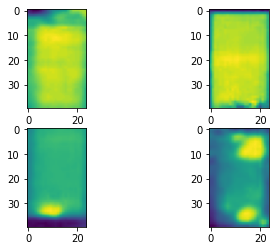

In [7]:
img1 = mpimg.imread('/content/InfraredSolarModules/images/13356.jpg') #No-Anomaly
img2 = mpimg.imread('/content/InfraredSolarModules/images/8488.jpg')  #Vegetation
img3 = mpimg.imread('/content/InfraredSolarModules/images/8489.jpg')  #Vegetation
img4 = mpimg.imread('/content/InfraredSolarModules/images/7464.jpg')  #Cracking

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img1)
axarr[0,1].imshow(img2)
axarr[1,0].imshow(img3)
axarr[1,1].imshow(img4)

# Transfer Learning

## Import Model

In [8]:
# General imports
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)
import numpy as np
import matplotlib.pyplot as plt
import os, datetime

# Shortcuts to keras if (however from tensorflow)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras import layers

In [ ]:
## The target image size can be fixed here (quadratic)
## The ImageDataGenerator() automatically scales the images accordingly (aspect ratio is changed)
#image_size_y = 40
#image_size_x = 24

In [9]:
 conv_base = keras.applications.vgg16.VGG16(weights="imagenet",
                                           include_top=False)
                                           #input_shape=(image_size_x, image_size_y, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Feature extraction without data augmentation

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    './train',
    image_size=(150, 150),
    batch_size=32,
    shuffle=False,
    label_mode="categorical")

validation_dataset = image_dataset_from_directory(
    './validation',
    image_size=(150, 150),
    batch_size=32,
    shuffle=False,
    label_mode="categorical")

In [ ]:
import numpy as np
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)

In [ ]:
inputs = keras.Input(shape=(4, 4, 512))
# Note the use of the Flatten layer before passing the
# features to a Dense layer
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.7)(x)
outputs = layers.Dense(8, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

### Train Model

In [ ]:
model.compile(loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])


logdir = os.path.join("logs_feature_extraction", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="feature_extraction.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
]

history = model.fit(
train_features, train_labels,
epochs=30,
validation_data=(val_features, val_labels),
callbacks=callbacks
)

#### Model Performance

In [ ]:
# Epoch Statistics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
# Validate Model
model.evaluate(val_features, val_labels)

#### Tensorboard

In [ ]:
# Load the TensorBoard notebook extension on google colab
%load_ext tensorboard

%tensorboard --logdir logs